In [117]:
import os
import sys
import ast
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'lte':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

In [129]:
def setup_profile(df, tag, start, end, mode='ul', left=pd.Timestamp.min, right=pd.Timestamp.max, fix=False, wsize=1):
    if pd.notna(end):
        # midpoint = start + (end - start) / 2
        midpoint = start
        intv = P.closed(max(start-pd.Timedelta(seconds=ImpactScope[tag][0]), left), min(end+pd.Timedelta(seconds=ImpactScope[tag][1]), right))
        if fix:
            intv = P.closed(max(start-pd.Timedelta(seconds=wsize), left), min(end+pd.Timedelta(seconds=wsize), right))
    else:
        midpoint = start
        intv = P.closed(max(start-pd.Timedelta(seconds=ImpactScope[tag][0]), left), min(start+pd.Timedelta(seconds=ImpactScope[tag][1]), right))
        if fix:
            intv = P.closed(max(start-pd.Timedelta(seconds=wsize), left), min(start+pd.Timedelta(seconds=wsize), right))
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - midpoint).dt.total_seconds()
    elif mode == 'dl':
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
    else: # 'pyl'
        df_plot = df.query('Timestamp >= @intv.lowe/r & Timestamp <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - midpoint).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    
    ts_group = df_plot.groupby(['cat_id'])
    table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
    table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
    table['PLR'] = table['PLR'] * 100
    # display(table)
    return table, intv

def merge_profile(tables, intrs):
    intr = np.mean(intrs)
    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    table['lost'] = table['lost'].astype('Int32')
    table['PLR'] = table['PLR'].astype('float32')
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        table['lost'] = table['lost_x'] + table['lost_y']
        table['PLR'] = 0
        table = table[['cat_id','tx_count','lost','PLR']]
    table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
    table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    return table, intr

def plot_profile(table, intr=0, title='', mode='lost', xlim=0, path='', flow='ul', stable_plr=0, plr=0, plr1=0):
    fig, ax = plt.subplots(figsize=(6, 4))
    if flow == 'ul':
        ax.set_title(f'Uplink: {title}')
    else: # 'dl'
        ax.set_title(f'Downlink: {title}')
    if xlim == 0:
        ax.set_xlim(table.iat[0, table.columns.get_loc('cat_id')], table.iat[-1, table.columns.get_loc('cat_id')])
    else:
        ax.set_xlim(-xlim, xlim)
    if mode == 'lost':
        ax.bar(table['cat_id'], table['lost'], width=0.01, alpha=0.97)
        ax.set_ylabel('Lost Number')
        ax.set_ylim(bottom=0)
    if mode == 'plr':
        ax.bar(table['cat_id'], table['PLR'], width=0.01, alpha=0.97)
        ax.set_ylabel('Packet Loss Rate (%)')
        ax.axhline(stable_plr, color='tab:pink', linestyle='--', label='Stable PLR')
        ax.axhline(plr1, color='tab:green', linestyle='--', label=f'{title} PLR')
        ax.text(-1.078*xlim, plr1, '{:.2f}'.format(plr1), ha='center', fontweight='bold', fontsize=10, color='tab:green')
        # ax.axhline(plr, color='tab:orange', linestyle='--', label=f'{title} PLR')
        # ax.text(-1.078*xlim, plr, '{:.2f}'.format(plr), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
        ax.legend()
        bleft = -ImpactScope[title][0]
        bright = ImpactScope[title][1]
        rect1 = patches.Rectangle((bleft, 0), bright-bleft, plr, ec=None, fc='#ffbc00', alpha=0.5)  # 左下角座標點, 寬度, 高度, 邊界顏色, 填滿顏色
        ax.add_patch(rect1)
        # ax.set_ylim(top=105)
        ax.set_ylim(bottom=0)
    intr /= 2
    # ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    # ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    ax.axvline(-intr, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{title}_{flow.upper()}_{mode}.png'), bbox_inches='tight', dpi=300)
    plt.show()

def plot_intrs(data, tag, path='', count=0):
    data = [s*1000 for s in data]
    
    # Plot the violin plot
    fig, ax = plt.subplots(figsize=(6, 1.5))
    ax.violinplot(data, vert=False, quantiles=[0.25, 0.5, 0.75])

    # Calculate and plot the mean and median values
    mean = np.mean(data)
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.text(mean, 0.58, '{:.1f}'.format(mean), ha='center', fontweight='bold', fontsize=10, color='r')
    ax.set_xlim(left=0)
    ax.set_yticks([])
    ax.set_title(f'{tag} ({count} ct.)')
    ax.set_xlabel('Handover Interruption Time (ms)')

    # Add legend and title
    ax.legend()
    
    # Show the plot
    plt.savefig(os.path.join(path, f'{tag}_intr_dist.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [105]:
# root = '/home/wmnlab/D/database'
root = '/Users/jackbedford/Desktop/MOXA/Code/data'
paths = [s for s in os.listdir(root) if s.startswith('202') and os.path.isdir(os.path.join(root, s))]

md_files = []

for date_dir in paths:
    datedir = os.path.join(root, date_dir)
    md_file = [os.path.join(datedir, s) for s in os.listdir(datedir) if s.endswith('.md')]
    md_files += md_file

md_files = sorted(md_files)

# Select dates
# md_files = md_files[:-1]
# md_files = [md_files[2]]
md_files = [s for s in md_files if '05-04' not in s and '05-07' not in s]
# md_files = md_files[:5]

pprint(md_files)

['/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/2023-03-16.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/2023-03-26.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/2023-04-01.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/2023-04-10.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/2023-04-17.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/2023-05-15.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-24/2023-05-24.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/2023-05-26.md']


In [106]:
class Experiment():
    
    def __init__(self, dir_name, setting):
        
        self.dir_name = dir_name
        self.setting = setting
        
    def __repr__(self):
        return f'{self.dir_name} -> {self.setting}'

exp_list = []

for md_file in md_files:
    
    md_f = open(md_file, 'r')
    lines = []
    l = md_f.readline()[:-1]
    
    while l:
        
        if l == '#endif':
            break
        lines.append(l)
        l = md_f.readline()[:-1]
        
    md_f.close()
    
    for exp, dic in zip(lines[::2], lines[1::2]):
        
        dictionary = ast.literal_eval(dic)
        parent_dir = os.path.dirname(md_file)
        experiment = Experiment(dir_name = os.path.join(parent_dir, exp), setting=dictionary)
        exp_list.append(experiment)
        
pprint(exp_list)

[/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/Bandlock_Udp_All_RM500Q -> {'qc00': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q -> {'qc00': 'B1B3', 'qc01': 'B1B8', 'qc02': 'LTE', 'qc03': 'All'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1 -> {'qc00': 'All', 'qc01': 'All', 'qc02': 'All', 'qc03': 'All'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment2 -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment3 -> {'qc00': 'LTE', 'qc01': 'All', 'qc02': 'B7B8', 'qc03': 'B7'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023

## Downlink

In [109]:
## Downlink
ImpactScope = {
    'LTE_HO': (5, 5),   # LTE_HO, MN_HO, SN_Rel_MN_HO
    'NR_HO': (7, 7),    # SN_HO, SN_Rel
    'RLF': (7, 7),      # SCG_Failure, MCG_Failure, NAS_Recovery
    'NR_Setup': (3, 3), # SN_Setup
}

In [110]:
sorter = ['LTE_HO',
          'NR_HO',
          'RLF',
          'NR_Setup',
]

# sorter1 = ['LTE_HO','MN_HO','SN_Rel_MN_HO',
#           'SN_HO','SN_Rel',
#           'SCG_Failure','MCG_Failure','NAS_Recovery',
#           'SN_Setup',
# ]

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}
dl_stable_pkt = 0
dl_stable_loss = 0

for exp in exp_list:
    dir_name = exp.dir_name
    devices = sorted(exp.setting.keys())
    for dev in devices:
        dev_folder = os.path.join(dir_name, dev)
        for trace in sorted(os.listdir(dev_folder)):
            if '#' not in trace:
                continue
            trace_folder = os.path.join(dev_folder, trace, 'data')
            ## read downlink
            data = os.path.join(trace_folder, 'udp_dnlk_loss_latency.pkl')
            print(data, os.path.isfile(data))
            df_dl = pd.read_pickle(data)
            df_dl = set_data(df_dl)
            ## read handover
            data = os.path.join(trace_folder, [s for s in os.listdir(trace_folder) if s.startswith('diag_log_') and s.endswith('_rrc.pkl')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_pickle(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            df = df_ho[~np.in1d(df_ho['ho_type'], ['Conn_Setup', 'Conn_Rel'])].copy().reset_index(drop=True)
            A = {}
            for tag in sorter:
                A[tag] = {'tables': [], 'intrs': []}
            _intv = P.singleton(pd.Timestamp.min)
            for i, row in df.iterrows():
                prior_row = df.iloc[i-1] if i != 0 else None
                post_row = df.iloc[i+1] if i != len(df)-1 else None
                ### peek the next event: avoid MN/LTE HO overlaps with handoverFailure
                if i != len(df)-1 and pd.notna(row.end) and row.end > post_row.start:
                    print(i, row.start, row.end, row.ho_type, row.cause)
                    print(i+1, post_row.start, post_row.end, post_row.ho_type, post_row.cause)
                    continue
                if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                    prior_row = df.iloc[i-2] if i > 1 else None
                ### basic timestamp
                tag = row.ho_type
                start, end = row.start, row.end
                intr = row.intr if pd.notna(row.intr) else 0
                ### set left, right limit
                if prior_row is not None:
                    if pd.notna(prior_row.end):
                        # left = prior_row.end
                        left = prior_row.end + (start - prior_row.end) / 2
                    else:
                        # left = prior_row.start
                        left = prior_row.start + (start - prior_row.start) / 2
                else:
                    left = pd.Timestamp.min
                if post_row is not None:
                    if pd.notna(end):
                        # right = post_row.start
                        right = end + (post_row.start - end) / 2
                    else:
                        # right = post_row.start
                        right = start + (post_row.start - start) / 2
                else:
                    right = pd.Timestamp.max
                ### re-classify
                if tag in ['LTE_HO','MN_HO','SN_Rel_MN_HO']:
                    tag = 'LTE_HO'
                elif tag in ['SN_HO','SN_Rel']:
                    tag = 'NR_HO'
                elif tag in ['SCG_Failure','MCG_Failure','NAS_Recovery']:
                    tag = 'RLF'
                elif tag in ['SN_Setup']:
                    tag = 'NR_Setup'
                else:
                    pass
                ### Setup profile
                table, intv = setup_profile(df_dl, tag, start, end, mode='dl', left=left, right=right)
                # print(intr)
                # display(table)
                A[tag]['tables'].append(table)
                A[tag]['intrs'].append(intr)
                ### count stable loss, pkt (1)
                if i == 0:
                    lower = pd.Timestamp.min
                    upper = intv.lower
                else:
                    lower = _intv.upper
                    upper = intv.lower
                df_tmp = df_dl.query('arr_time > @lower & arr_time <= @upper').copy().reset_index(drop=True)
                dl_stable_pkt += len(df_tmp)
                dl_stable_loss += sum(df_tmp['lost'])
                _intv = intv
            ### count stable loss, pkt (2)
            lower = _intv.upper
            upper = pd.Timestamp.max
            df_tmp = df_dl.query('arr_time > @lower & arr_time <= @upper').copy().reset_index(drop=True)
            dl_stable_pkt += len(df_tmp)
            dl_stable_loss += sum(df_tmp['lost'])
            for tag in sorter:
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'])
                # print('HO Count:', len(df))
                D[tag]['tables'].append(table)
                D[tag]['intrs'] = [*D[tag]['intrs'], *A[tag]['intrs']]
                D[tag]['count'].append(len(A[tag]['tables']))
            dl_stable_plr = dl_stable_loss / (dl_stable_pkt + 1e-9) * 100
            print(dl_stable_loss, dl_stable_pkt, round(dl_stable_plr, 3))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.pkl True
0 78631 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_dnlk_loss_latency.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/diag_log_qc00_2023-03-16_19-32-43_rrc.pkl True
0 168624 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/udp_dnlk_loss_latency.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/diag_log_qc00_2023-03-16_19-38-36_rrc.pkl True
0 266215 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#04/data/udp_dnlk_loss_latency.pkl True
/Use

### Plot

In [138]:
## Downlink
ImpactScope = {
    'LTE_HO': (2, 2),   # LTE_HO, MN_HO, SN_Rel_MN_HO
    'NR_HO': (3.5, 4),    # SN_HO, SN_Rel
    'RLF': (5.5, 2),      # SCG_Failure, MCG_Failure, NAS_Recovery
    'NR_Setup': (0.5, 2), # SN_Setup
}

## Downlink
# ImpactScope = {
#     'LTE_HO': (5, 5),   # LTE_HO, MN_HO, SN_Rel_MN_HO
#     'NR_HO': (7, 7),    # SN_HO, SN_Rel
#     'RLF': (7, 7),      # SCG_Failure, MCG_Failure, NAS_Recovery
#     'NR_Setup': (3, 3), # SN_Setup
# }

LTE_HO
HO Count: 6611
Average Duration: 0.020145122219914477 seconds
Average PLR: 0.8434844798314695 %
Stable PLR: 0.02553652587394685 %


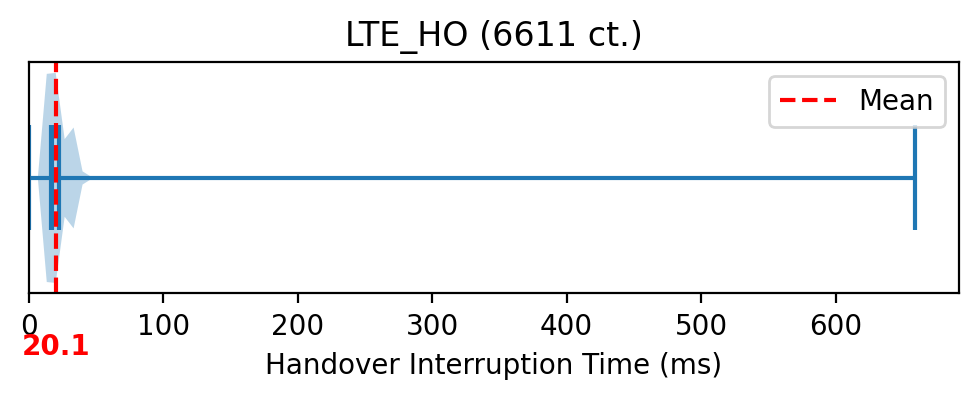

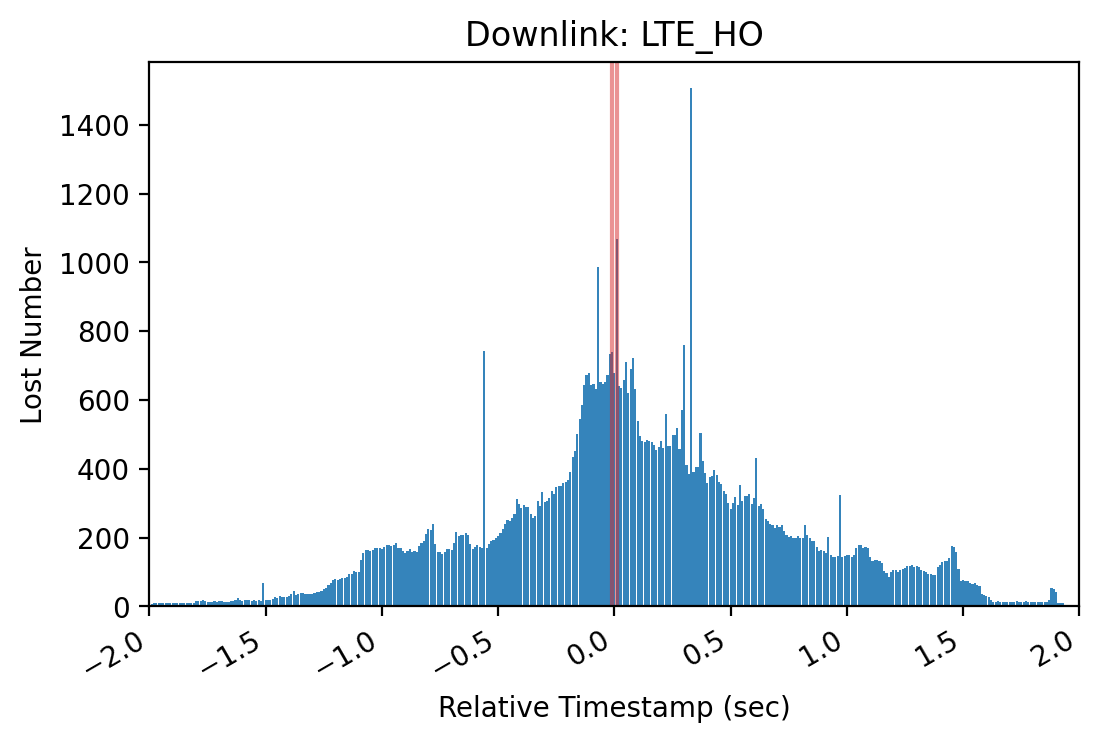

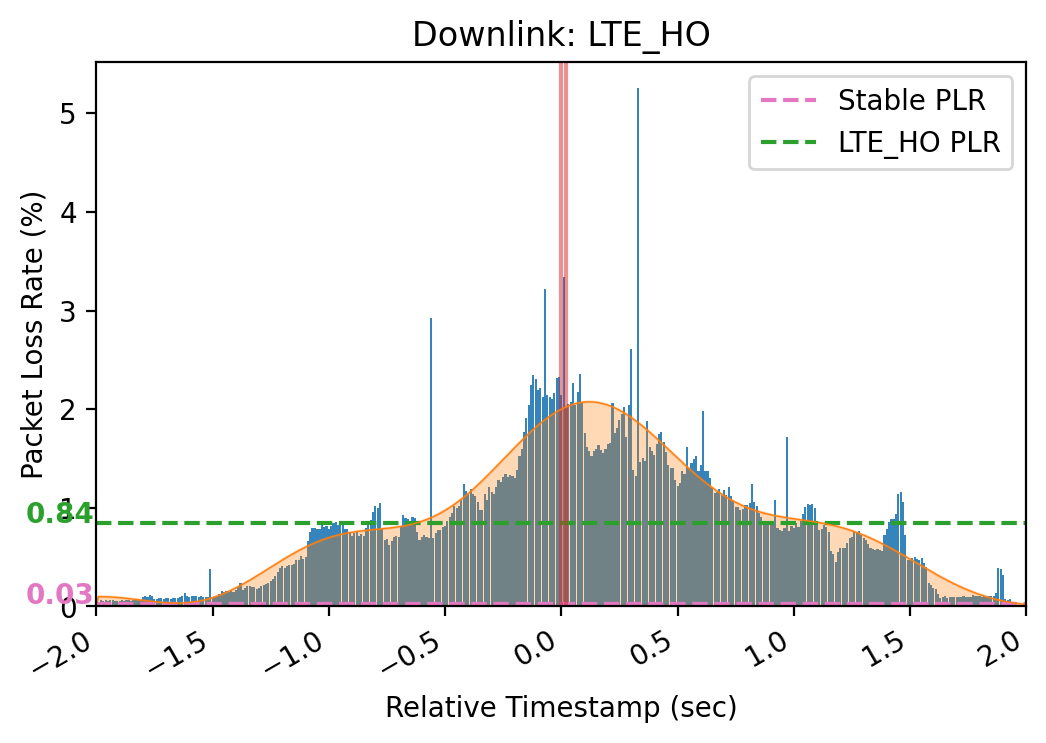

NR_HO
HO Count: 4993
Average Duration: 0.015954905064042003 seconds
Average PLR: 0.37434015532770487 %
Stable PLR: 0.02553652587394685 %


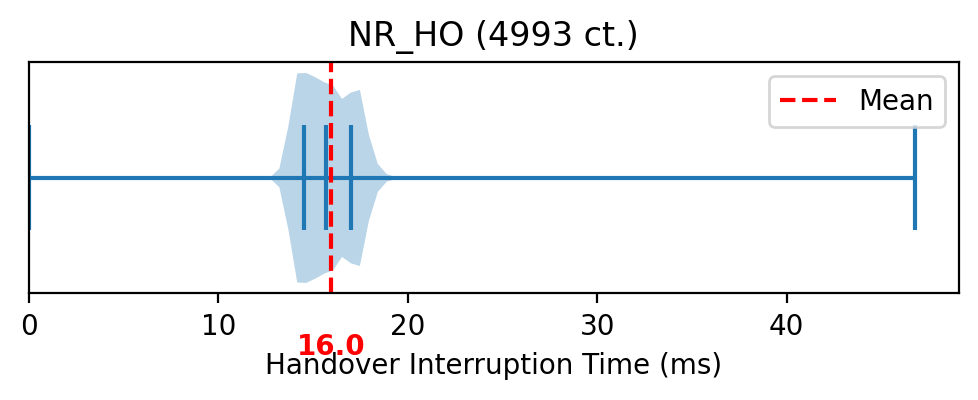

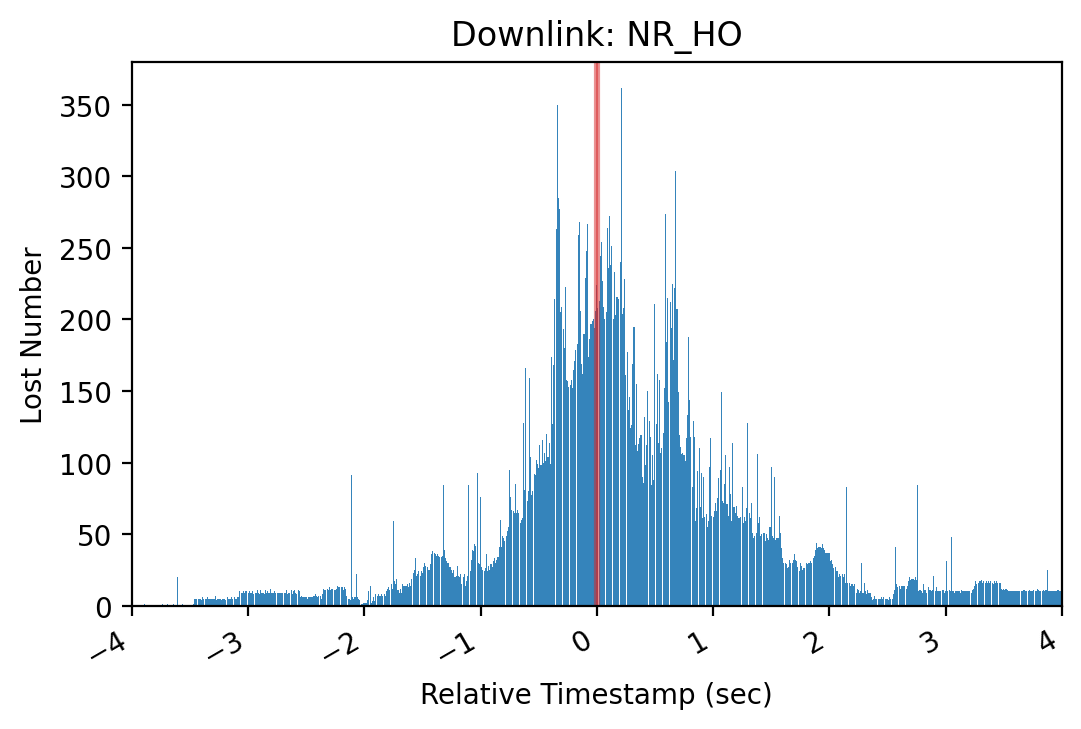

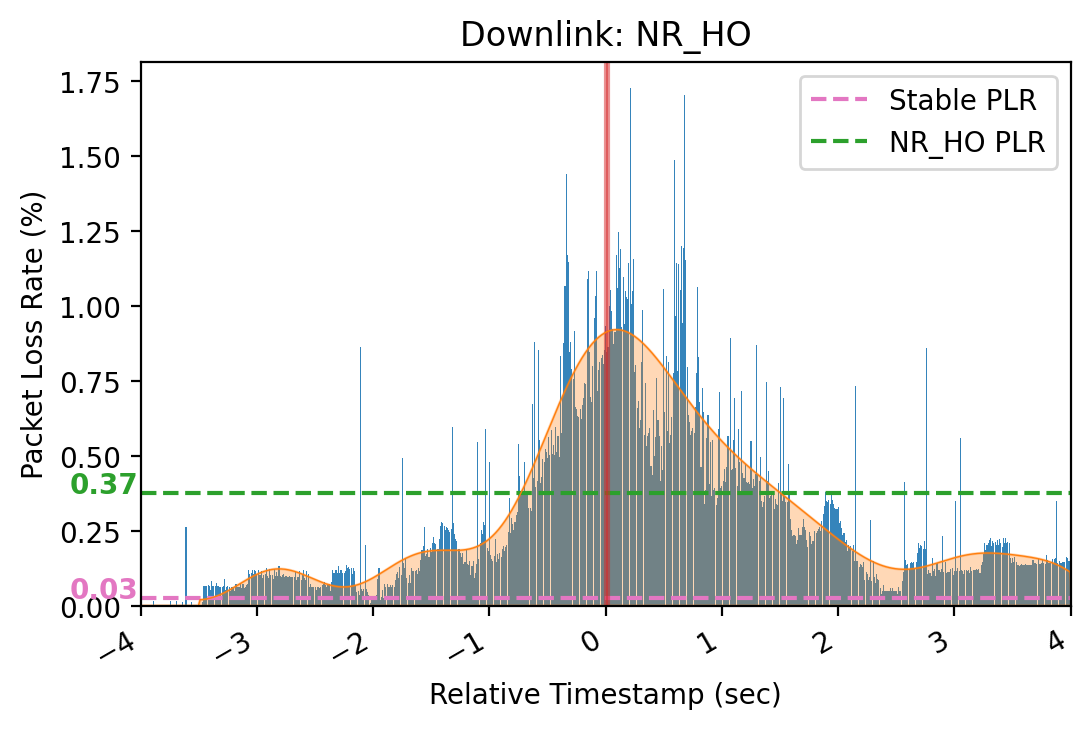

RLF
HO Count: 646
Average Duration: 0.07891214554177903 seconds
Average PLR: 18.9534728359665 %
Stable PLR: 0.02553652587394685 %


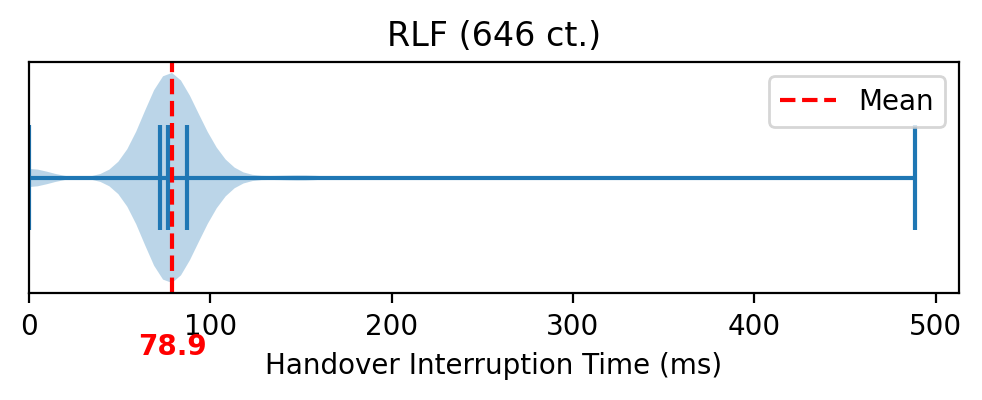

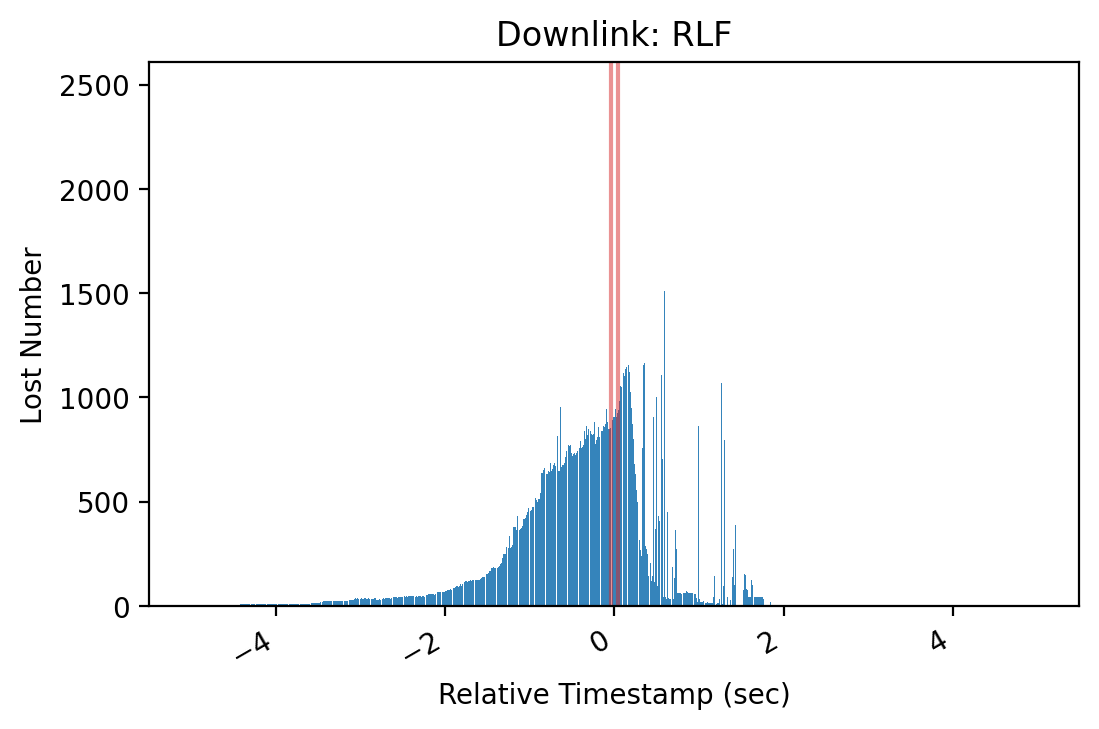

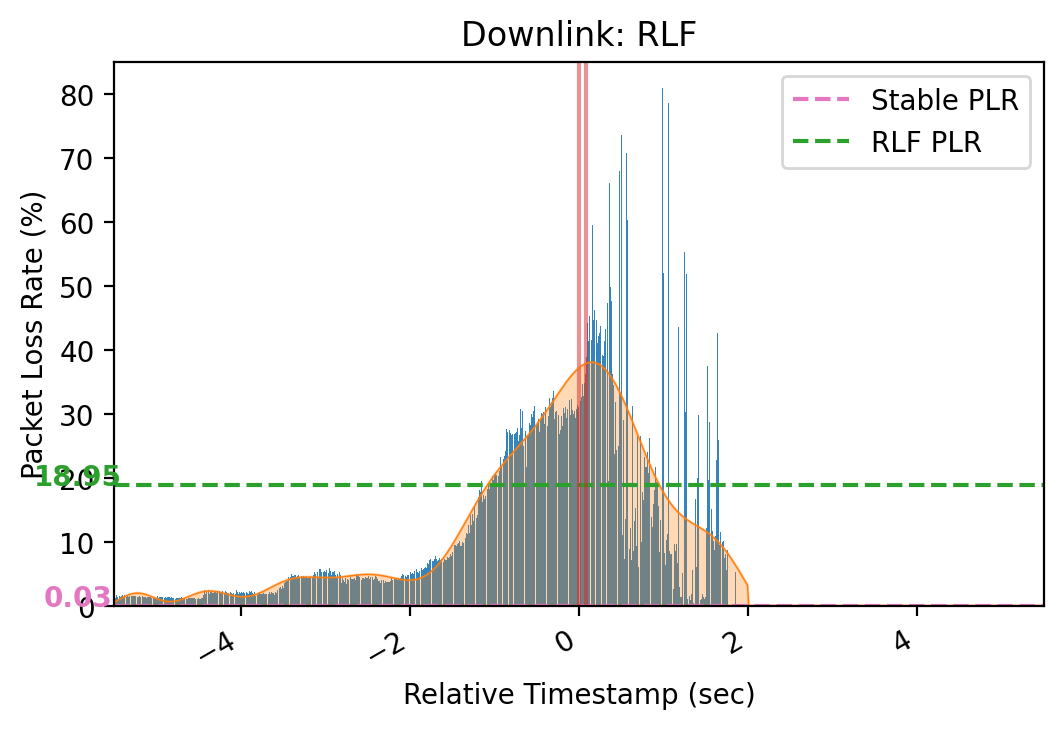

NR_Setup
HO Count: 1196
Average Duration: 0.0323787399584795 seconds
Average PLR: 7.0513123566706595 %
Stable PLR: 0.02553652587394685 %


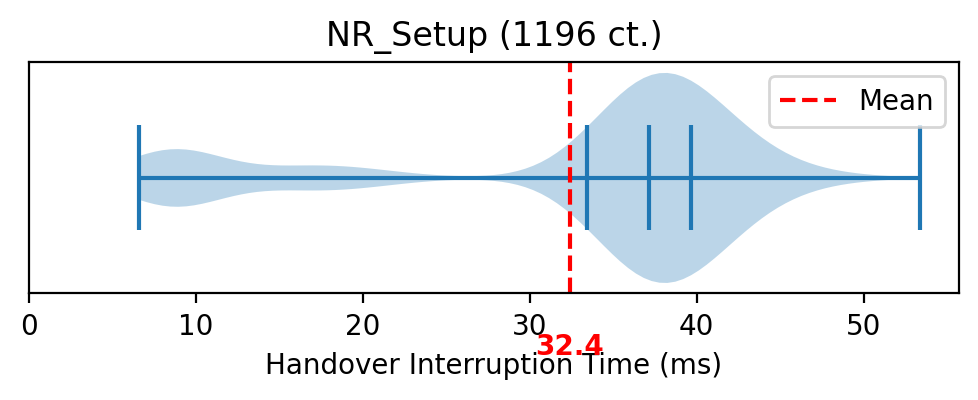

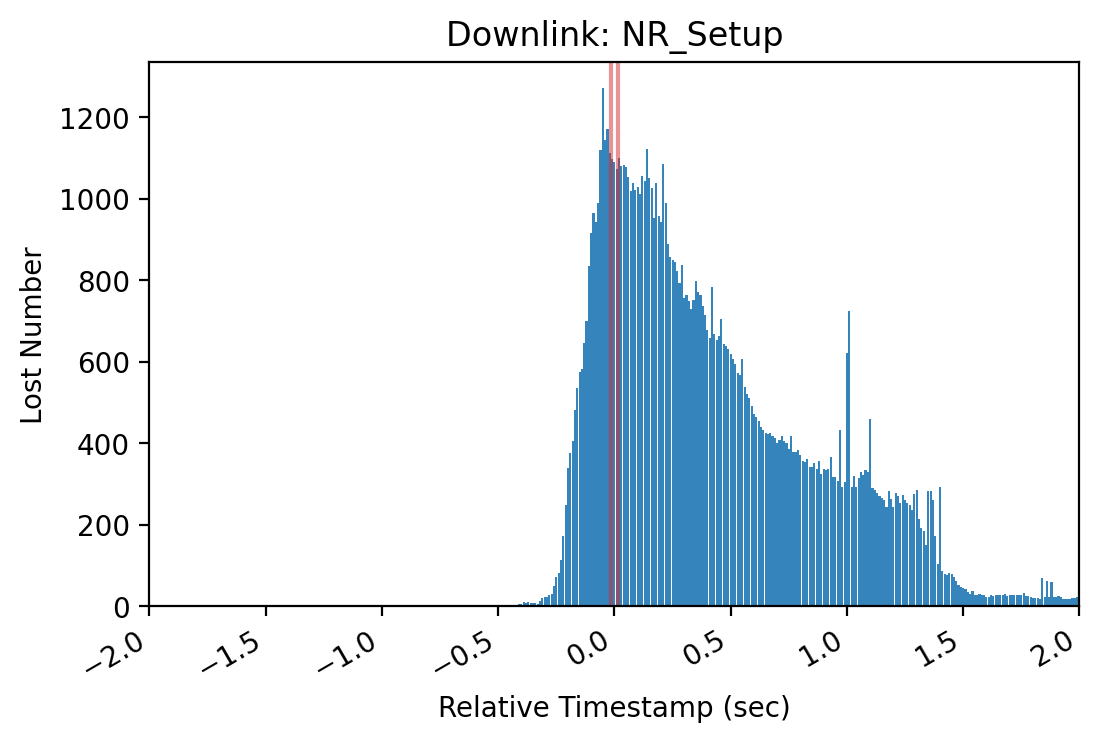

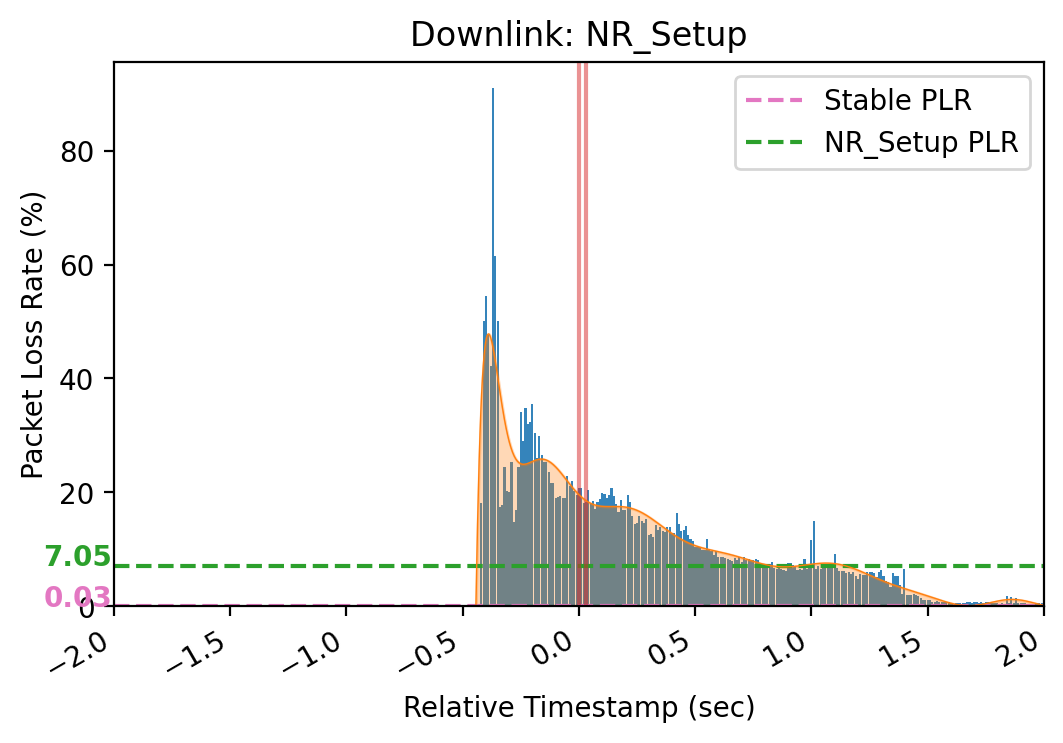

In [139]:
import warnings

def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

coef_dl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('HO Count:', sum(D[tag]['count']))
    print('Average Duration:', intr, 'seconds')
    # display(table)
    
    _table = table.query('PLR > @dl_stable_plr').copy().reset_index(drop=True)
    # _table = table.copy().reset_index(drop=True)
    tcount = sum(_table['tx_count'])
    lcount = sum(_table['lost'])
    plr = lcount / (tcount + 1e-9) * 100
    print('Average PLR:', plr, '%')
    print('Stable PLR:', dl_stable_plr, '%')
    
    path = './temp'
    plot_intrs(D[tag]['intrs'], tag, path=path, count=sum(D[tag]['count']))
    
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f'Downlink: {tag}')
    ax.set_xlim(-xlim, xlim)
    ax.bar(table['cat_id'], table['lost'], width=0.009, alpha=0.9)
    ax.set_ylabel('Lost Number')
    ax.set_ylim(bottom=0)
    _intr = intr / 2
    ax.axvline(-_intr, color='tab:red', alpha=0.5)
    ax.axvline(_intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    # plt.savefig(os.path.join(path, f'{tag}_DL_lost.png'), bbox_inches='tight', dpi=300)
    plt.show()
    
    
    # xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    # plot_profile(table1, intr=intr1, title=tag, mode='plr', xlim=wsize, path=path, flow='dl', stable_plr=stable_plr, plr=plr, plr1=plr1)
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f'Downlink: {tag}')
    ax.set_xlim(-xlim, xlim)
    ax.bar(table['cat_id'], table['PLR'], width=0.009, alpha=0.9)
    ax.set_ylabel('Packet Loss Rate (%)')
    ax.set_ylim(bottom=0)
    if ax.get_ylim()[1] < 1:
        ax.set_ylim(top=1.05)
    
    ax.axhline(dl_stable_plr, color='tab:pink', linestyle='--', label='Stable PLR')
    ax.text(-1.078*xlim, dl_stable_plr, '{:.2f}'.format(dl_stable_plr), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
    ax.axhline(plr, color='tab:green', linestyle='--', label=f'{tag} PLR')
    ax.text(-1.078*xlim, plr, '{:.2f}'.format(plr), ha='center', fontweight='bold', fontsize=10, color='tab:green')
    ax.legend()
    bleft = -ImpactScope[tag][0]
    bright = ImpactScope[tag][1]
    
    _intr = intr / 2
    # ax.axvline(-_intr, color='tab:red', alpha=0.5)
    # ax.axvline(_intr, color='tab:red', alpha=0.5)
    ax.axvline(0, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    
    x = np.asarray(table['cat_id'], dtype=np.float64)
    y = np.asarray(table['PLR'], dtype=np.float64)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        z = np.polyfit(x, y, 70)
        p = np.poly1d(z)
    xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
    
    coef = list(p.coefficients)
    if len(coef) < 71:
        coef += [0]*(71-len(coef))
    coef_dl.loc[tag] = [bleft, bright, *coef]
    
    ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
    ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
    
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{tag}_DL_PLR.png'), bbox_inches='tight', dpi=300)
    plt.show()

## Uplink

In [113]:
## Uplink
ImpactScope = {
    'LTE_HO': (5, 5),   # LTE_HO, MN_HO, SN_Rel_MN_HO
    'NR_HO': (7, 7),    # SN_HO, SN_Rel
    'RLF': (7, 7),      # SCG_Failure, MCG_Failure, NAS_Recovery
    'NR_Setup': (3, 3), # SN_Setup
}

In [114]:
sorter = ['LTE_HO',
          'NR_HO',
          'RLF',
          'NR_Setup',
]

# sorter1 = ['LTE_HO','MN_HO','SN_Rel_MN_HO',
#           'SN_HO','SN_Rel',
#           'SCG_Failure','MCG_Failure','NAS_Recovery',
#           'SN_Setup',
# ]

U = {}
for tag in sorter:
    U[tag] = {'tables': [], 'intrs': [], 'count': []}
ul_stable_pkt = 0
ul_stable_loss = 0

for exp in exp_list:
    dir_name = exp.dir_name
    devices = sorted(exp.setting.keys())
    for dev in devices:
        dev_folder = os.path.join(dir_name, dev)
        for trace in sorted(os.listdir(dev_folder)):
            if '#' not in trace:
                continue
            trace_folder = os.path.join(dev_folder, trace, 'data')
            ## read downlink
            data = os.path.join(trace_folder, 'udp_uplk_loss_latency.pkl')
            print(data, os.path.isfile(data))
            df_ul = pd.read_pickle(data)
            df_ul = set_data(df_ul)
            ## read handover
            data = os.path.join(trace_folder, [s for s in os.listdir(trace_folder) if s.startswith('diag_log_') and s.endswith('_rrc.pkl')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_pickle(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            df = df_ho[~np.in1d(df_ho['ho_type'], ['Conn_Setup', 'Conn_Rel'])].copy().reset_index(drop=True)
            A = {}
            for tag in sorter:
                A[tag] = {'tables': [], 'intrs': []}
            _intv = P.singleton(pd.Timestamp.min)
            for i, row in df.iterrows():
                prior_row = df.iloc[i-1] if i != 0 else None
                post_row = df.iloc[i+1] if i != len(df)-1 else None
                ### peek the next event: avoid MN/LTE HO overlaps with handoverFailure
                if i != len(df)-1 and pd.notna(row.end) and row.end > post_row.start:
                    print(i, row.start, row.end, row.ho_type, row.cause)
                    print(i+1, post_row.start, post_row.end, post_row.ho_type, post_row.cause)
                    continue
                if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                    prior_row = df.iloc[i-2] if i > 1 else None
                ### basic timestamp
                tag = row.ho_type
                start, end = row.start, row.end
                intr = row.intr if pd.notna(row.intr) else 0
                ### set left, right limit
                if prior_row is not None:
                    if pd.notna(prior_row.end):
                        # left = prior_row.end
                        left = prior_row.end + (start - prior_row.end) / 2
                    else:
                        # left = prior_row.start
                        left = prior_row.start + (start - prior_row.start) / 2
                else:
                    left = pd.Timestamp.min
                if post_row is not None:
                    if pd.notna(end):
                        # right = post_row.start
                        right = end + (post_row.start - end) / 2
                    else:
                        # right = post_row.start
                        right = start + (post_row.start - start) / 2
                else:
                    right = pd.Timestamp.max
                ### re-classify
                if tag in ['LTE_HO','MN_HO','SN_Rel_MN_HO']:
                    tag = 'LTE_HO'
                elif tag in ['SN_HO','SN_Rel']:
                    tag = 'NR_HO'
                elif tag in ['SCG_Failure','MCG_Failure','NAS_Recovery']:
                    tag = 'RLF'
                elif tag in ['SN_Setup']:
                    tag = 'NR_Setup'
                else:
                    pass
                ### Setup profile
                table, intv = setup_profile(df_ul, tag, start, end, mode='ul', left=left, right=right)
                # print(intr)
                # display(table)
                A[tag]['tables'].append(table)
                A[tag]['intrs'].append(intr)
                ### count stable loss, pkt (1)
                if i == 0:
                    lower = pd.Timestamp.min
                    upper = intv.lower
                else:
                    lower = _intv.upper
                    upper = intv.lower
                df_tmp = df_ul.query('xmit_time > @lower & xmit_time <= @upper').copy().reset_index(drop=True)
                ul_stable_pkt += len(df_tmp)
                ul_stable_loss += sum(df_tmp['lost'])
                _intv = intv
            ### count stable loss, pkt (2)
            lower = _intv.upper
            upper = pd.Timestamp.max
            df_tmp = df_ul.query('xmit_time > @lower & xmit_time <= @upper').copy().reset_index(drop=True)
            ul_stable_pkt += len(df_tmp)
            ul_stable_loss += sum(df_tmp['lost'])
            for tag in sorter:
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'])
                # print('HO Count:', len(df))
                U[tag]['tables'].append(table)
                U[tag]['intrs'] = [*U[tag]['intrs'], *A[tag]['intrs']]
                U[tag]['count'].append(len(A[tag]['tables']))
            ul_stable_plr = ul_stable_loss / (ul_stable_pkt + 1e-9) * 100
            print(ul_stable_loss, ul_stable_pkt, round(ul_stable_plr, 3))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_uplk_loss_latency.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.pkl True
0 78501 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_uplk_loss_latency.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/diag_log_qc00_2023-03-16_19-32-43_rrc.pkl True
0 168484 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/udp_uplk_loss_latency.pkl True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/diag_log_qc00_2023-03-16_19-38-36_rrc.pkl True
0 266110 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#04/data/udp_uplk_loss_latency.pkl True
/Use

### Plot

In [140]:
## Uplink
ImpactScope = {
    'LTE_HO': (2, 2),   # LTE_HO, MN_HO, SN_Rel_MN_HO
    'NR_HO': (2, 2),    # SN_HO, SN_Rel
    'RLF': (4.5, 3),      # SCG_Failure, MCG_Failure, NAS_Recovery
    'NR_Setup': (0.5, 2), # SN_Setup
}

## Uplink
# ImpactScope = {
#     'LTE_HO': (5, 5),   # LTE_HO, MN_HO, SN_Rel_MN_HO
#     'NR_HO': (7, 7),    # SN_HO, SN_Rel
#     'RLF': (7, 7),      # SCG_Failure, MCG_Failure, NAS_Recovery
#     'NR_Setup': (3, 3), # SN_Setup
# }

LTE_HO
HO Count: 6611
Average Duration: 0.020145122219914477 seconds
Average PLR: 0.24528329185258368 %
Stable PLR: 0.12510969018820092 %


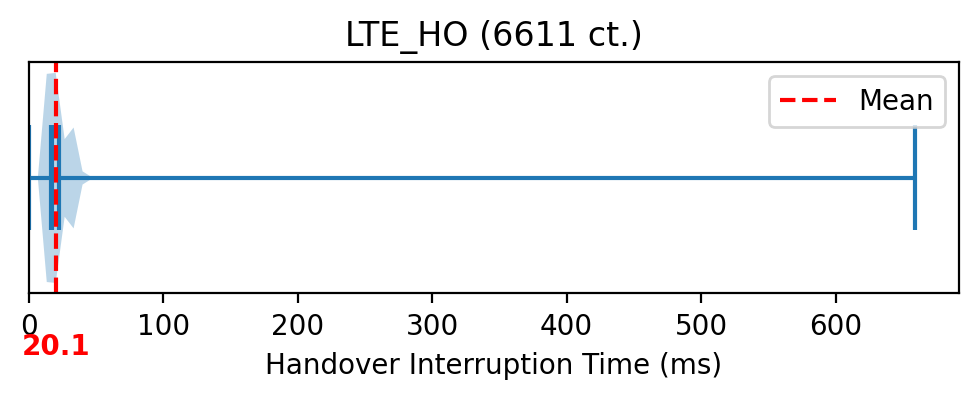

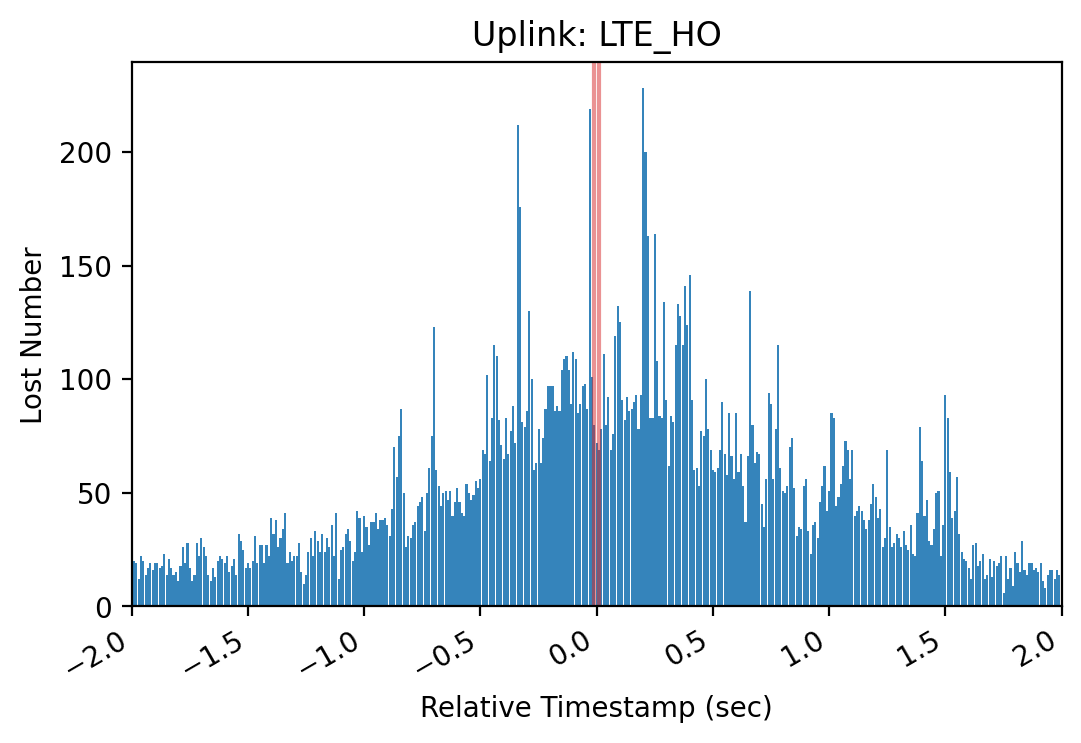

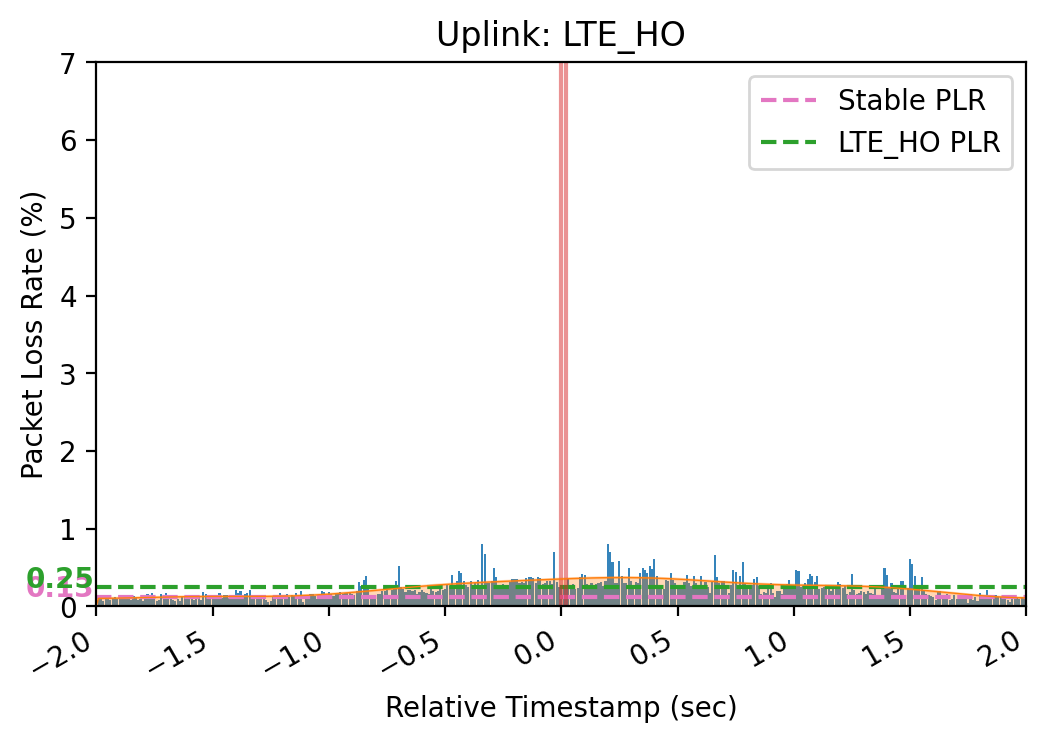

NR_HO
HO Count: 4993
Average Duration: 0.015954905064042003 seconds
Average PLR: 0.1719294293213361 %
Stable PLR: 0.12510969018820092 %


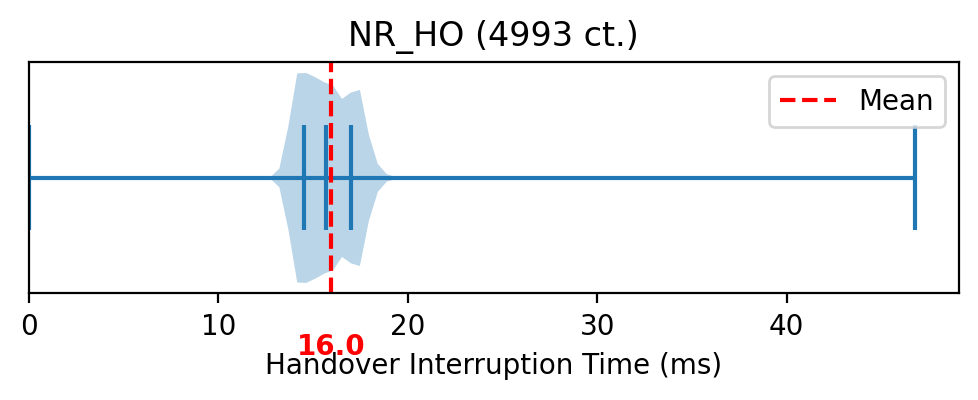

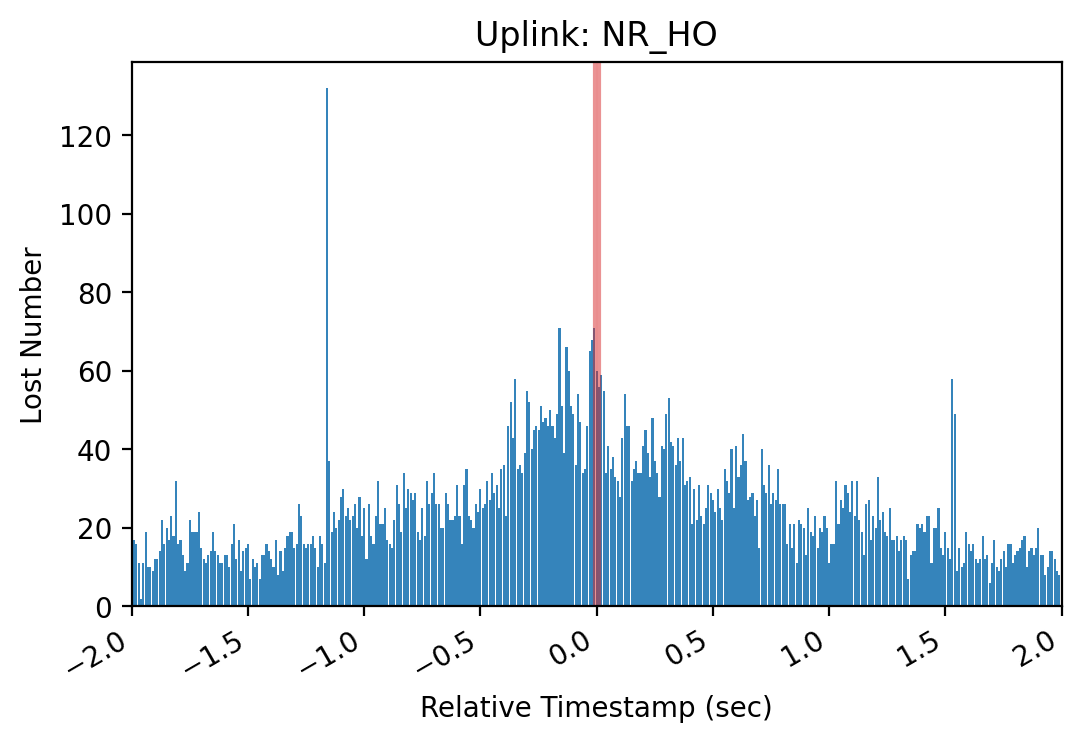

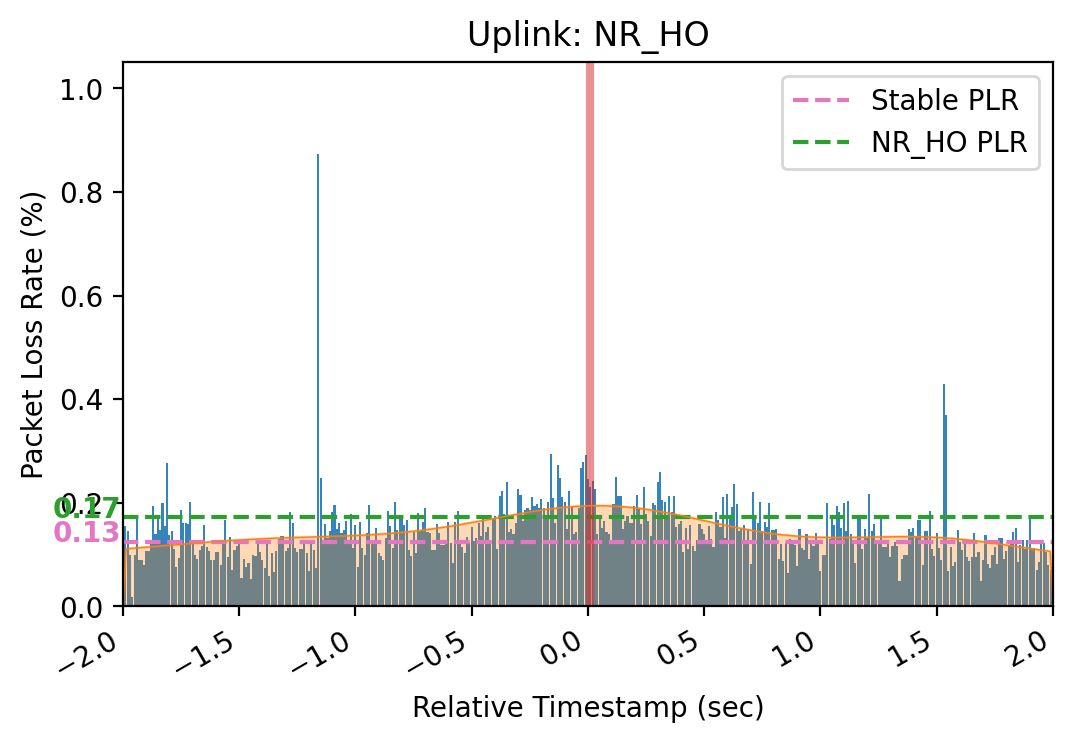

RLF
HO Count: 646
Average Duration: 0.07891214554177903 seconds
Average PLR: 1.7327816087706167 %
Stable PLR: 0.12510969018820092 %


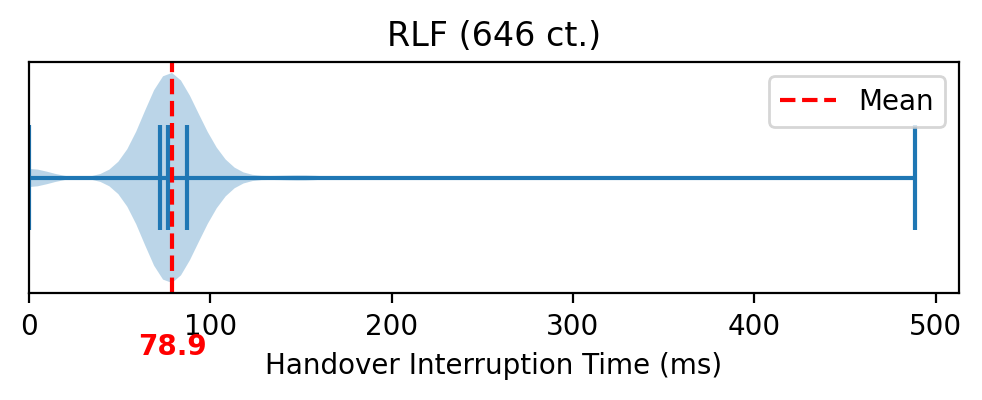

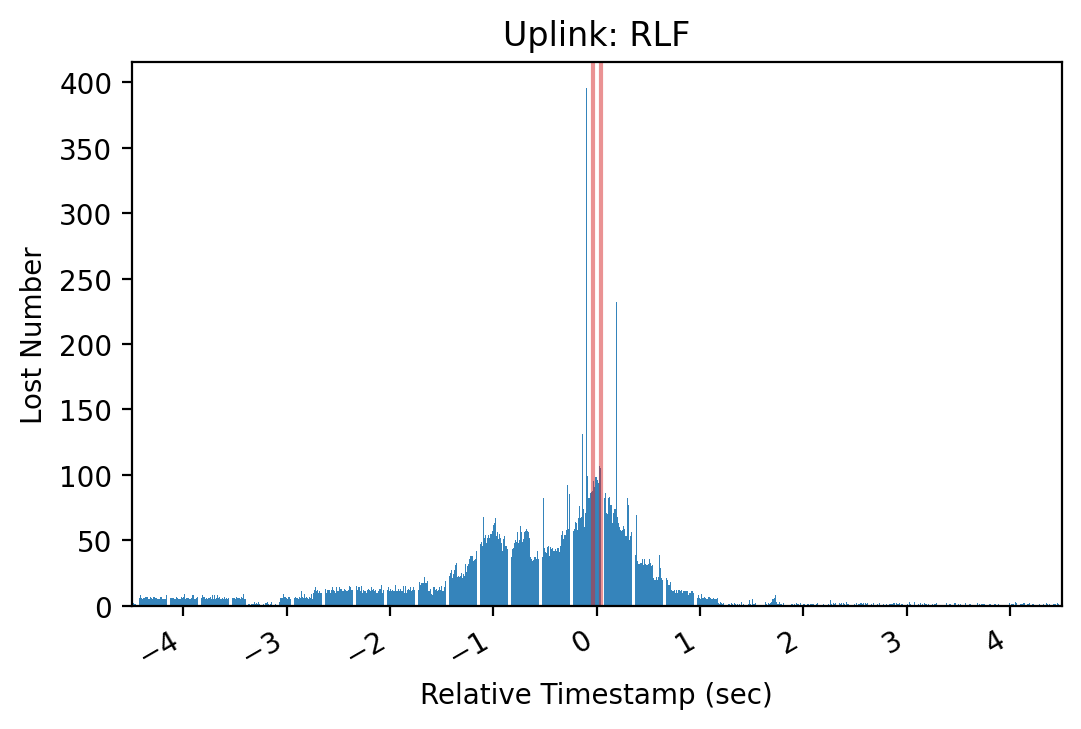

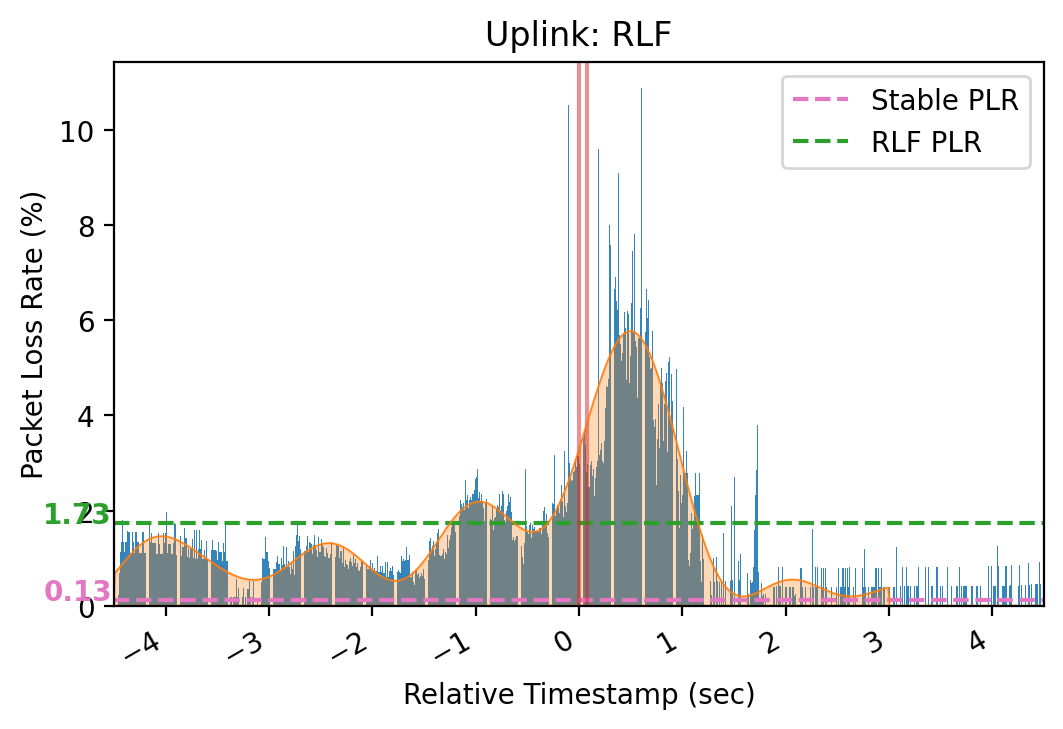

NR_Setup
HO Count: 1196
Average Duration: 0.0323787399584795 seconds
Average PLR: 1.2504370775283278 %
Stable PLR: 0.12510969018820092 %


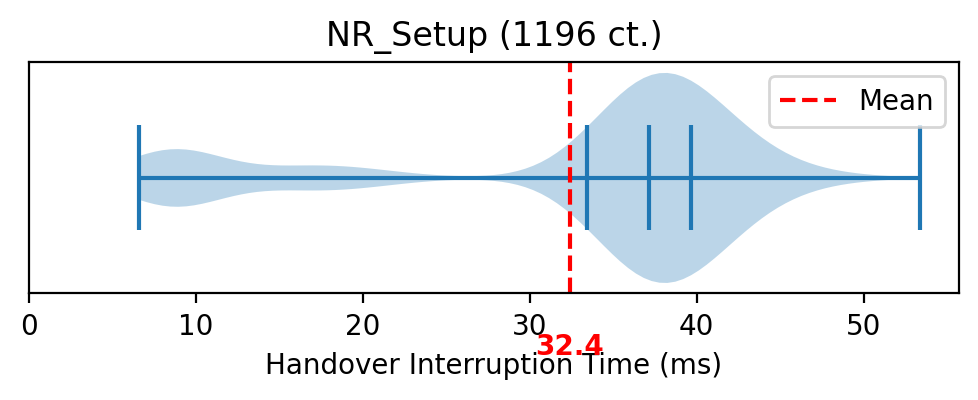

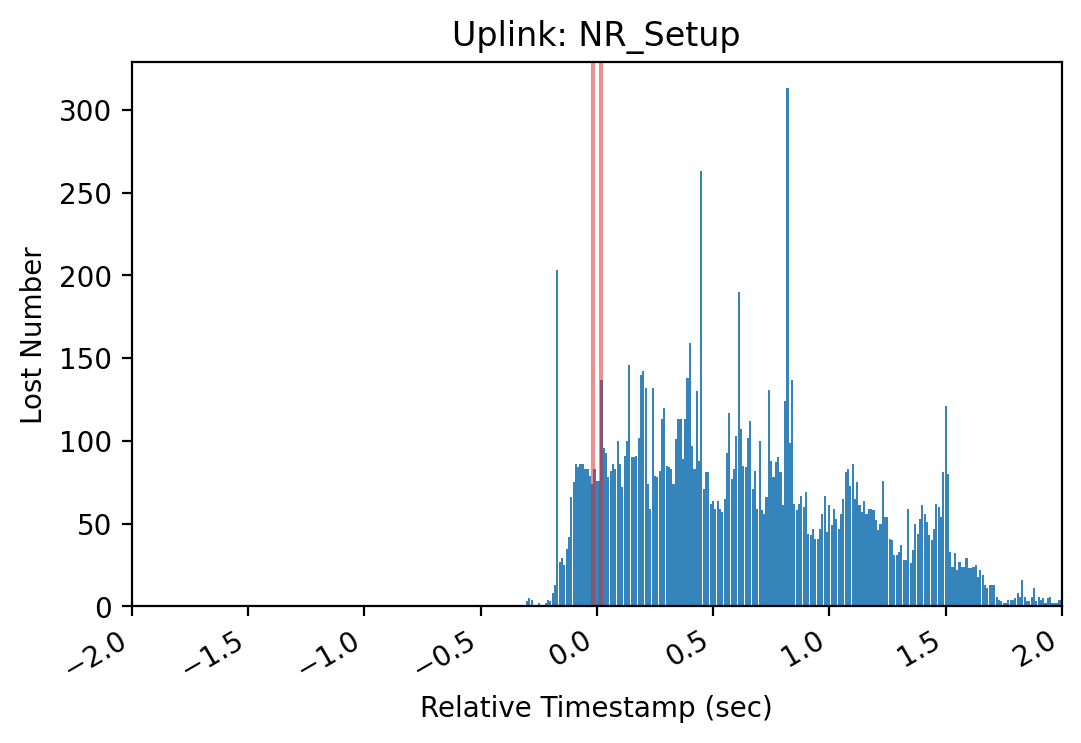

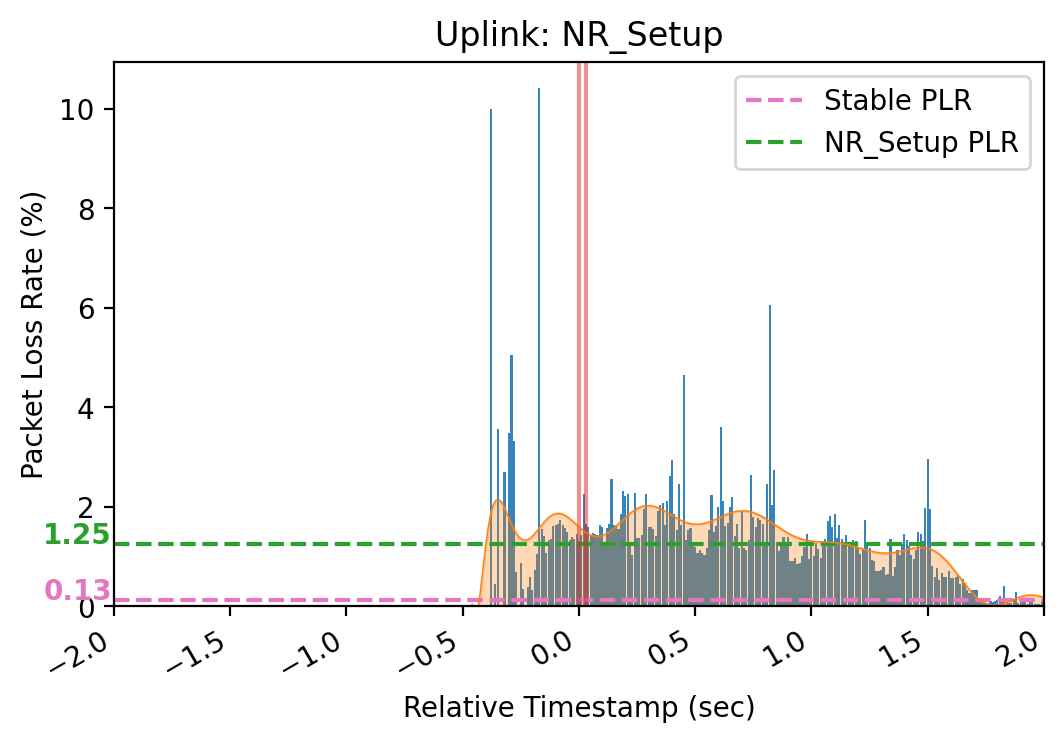

In [141]:
import warnings

def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

coef_ul = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
for tag in sorter:
    if len(U[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(U[tag]['tables'], U[tag]['intrs'])
    print('HO Count:', sum(U[tag]['count']))
    print('Average Duration:', intr, 'seconds')
    # display(table)
    
    _table = table.query('PLR > @ul_stable_plr').copy().reset_index(drop=True)
    # _table = table.copy().reset_index(drop=True)
    tcount = sum(_table['tx_count'])
    lcount = sum(_table['lost'])
    plr = lcount / (tcount + 1e-9) * 100
    print('Average PLR:', plr, '%')
    print('Stable PLR:', ul_stable_plr, '%')
    
    path = './temp'
    plot_intrs(U[tag]['intrs'], tag, path=path, count=sum(U[tag]['count']))
    
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f'Uplink: {tag}')
    ax.set_xlim(-xlim, xlim)
    ax.bar(table['cat_id'], table['lost'], width=0.009, alpha=0.9)
    ax.set_ylabel('Lost Number')
    ax.set_ylim(bottom=0)
    _intr = intr / 2
    ax.axvline(-_intr, color='tab:red', alpha=0.5)
    ax.axvline(_intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    # plt.savefig(os.path.join(path, f'{tag}_UL_lost.png'), bbox_inches='tight', dpi=300)
    plt.show()
    
    
    # xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    # plot_profile(table1, intr=intr1, title=tag, mode='plr', xlim=wsize, path=path, flow='dl', stable_plr=stable_plr, plr=plr, plr1=plr1)
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f'Uplink: {tag}')
    ax.set_xlim(-xlim, xlim)
    ax.bar(table['cat_id'], table['PLR'], width=0.009, alpha=0.9)
    ax.set_ylabel('Packet Loss Rate (%)')
    ax.set_ylim(bottom=0)
    if ax.get_ylim()[1] < 1:
        ax.set_ylim(top=1.05)
    
    ax.axhline(ul_stable_plr, color='tab:pink', linestyle='--', label='Stable PLR')
    ax.text(-1.078*xlim, ul_stable_plr, '{:.2f}'.format(ul_stable_plr), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
    ax.axhline(plr, color='tab:green', linestyle='--', label=f'{tag} PLR')
    ax.text(-1.078*xlim, plr, '{:.2f}'.format(plr), ha='center', fontweight='bold', fontsize=10, color='tab:green')
    ax.legend()
    bleft = -ImpactScope[tag][0]
    bright = ImpactScope[tag][1]
    
    _intr = intr / 2
    # ax.axvline(-_intr, color='tab:red', alpha=0.5)
    # ax.axvline(_intr, color='tab:red', alpha=0.5)
    ax.axvline(0, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    
    x = np.asarray(table['cat_id'], dtype=np.float64)
    y = np.asarray(table['PLR'], dtype=np.float64)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        z = np.polyfit(x, y, 70)
        p = np.poly1d(z)
    xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
    
    coef = list(p.coefficients)
    if len(coef) < 71:
        coef += [0]*(71-len(coef))
    coef_ul.loc[tag] = [bleft, bright, *list(coef)]
    
    ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
    ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
    
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{tag}_UL_PLR.png'), bbox_inches='tight', dpi=300)
    plt.show()

## Output coefficients

In [144]:
display(coef_dl)
pd.to_pickle(coef_dl, './coef_dl.pkl')

,lower_bd,upper_bd,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTE_HO,-2.0,2.0,-3.444771e-44,1.162487e-42,-7.991951e-42,-3.122363e-41,3.321365e-40,-6.009565e-40,8.299821e-39,-2.160823e-38,-7.270734e-38,-1.603783e-37,-7.478111e-36,2.919129e-35,-1.685259e-34,1.455240e-33,-7.094495e-34,2.352984e-32,7.234416e-32,-7.000175e-31,3.133574e-30,-5.169957e-29,9.629433e-29,-1.213714e-27,2.310143e-27,7.494341e-27,1.584759e-27,1.454002e-24,-3.528003e-24,4.220455e-23,-1.746672e-22,-1.399255e-23,-2.541932e-21,-4.014649e-20,1.371136e-19,-1.133162e-18,7.908123e-18,7.501402e-18,6.015577e-17,1.207761e-15,-8.260758e-15,1.684726e-14,-2.363207e-13,-8.195557e-13,6.688543e-12,-2.314626e-11,3.293660e-10,6.141269e-10,-8.571531e-09,1.687929e-08,-2.901501e-07,-7.111377e-07,1.782443e-05,6.446832e-06,-4.179768e-04,0.000095,0.005864,-0.003101,-0.054461,0.038051,0.345186,-0.269964,-1.490286,1.186708,4.269969,-3.190537,-7.703279,4.905141,8.056050,-3.789455,-4.635600,1.218711,2.000008
NR_HO,-3.5,4.0,1.144078e-51,2.986887e-50,-2.328597e-49,-6.409286e-48,1.258512e-47,3.807067e-46,2.242038e-46,4.912177e-45,-2.128533e-44,-7.090714e-43,-9.462417e-43,-2.551355e-41,1.382651e-41,7.740454e-40,2.530594e-39,8.523483e-38,7.475028e-38,1.633926e-36,-2.260455e-36,-1.293694e-34,-2.676095e-34,-9.565966e-33,-7.323721e-33,-1.188148e-31,2.572146e-31,1.779023e-29,2.802810e-29,1.074197e-27,6.774071e-28,2.302719e-27,-3.284244e-26,-2.563197e-24,-2.811219e-24,-1.037819e-22,-3.443405e-23,2.811756e-21,4.789681e-21,3.479358e-19,2.098714e-19,1.612729e-18,-4.598820e-18,-8.611022e-16,-4.655168e-16,-1.296224e-14,4.161689e-15,2.242658e-12,6.459963e-13,4.279176e-12,-1.338781e-11,-6.079414e-09,4.569618e-10,3.041556e-07,-6.088255e-08,-0.000008,0.000003,0.000138,-0.000085,-0.001565,0.001383,0.011973,-0.014240,-0.059832,0.092756,0.182829,-0.370049,-0.293065,0.853551,0.123453,-1.089040,0.198807,0.911759
RLF,-5.5,2.0,-8.882916e-51,3.027764e-50,1.616014e-48,-2.557015e-48,-6.594662e-47,-2.174819e-46,-2.708849e-45,1.342083e-44,9.576807e-44,1.094048e-42,8.793753e-42,-3.639828e-42,8.643710e-41,-3.745812e-39,-1.781946e-38,-1.783366e-37,-9.792899e-37,2.444747e-36,1.345633e-36,7.075780e-34,2.578083e-33,3.206154e-32,1.130333e-31,-4.602034e-31,-1.831456e-30,-1.287232e-28,-3.856502e-28,-5.541005e-27,-1.089558e-26,1.241981e-25,6.639995e-25,2.420394e-23,5.533559e-23,7.291123e-22,-1.678295e-22,-4.808174e-20,-1.710362e-19,-4.208330e-18,-3.293241e-18,2.713685e-17,4.806818e-16,1.465076e-14,1.364730e-14,1.156580e-13,-1.569681e-12,-4.918569e-11,-1.597649e-11,2.295778e-10,5.452036e-09,1.614435e-07,-2.586719e-07,-9.866713e-06,6.136692e-06,0.000310,-0.000072,-0.006144,0.000023,0.081492,0.012640,-0.728394,-0.197747,4.293904,1.538136,-15.852201,-6.798955,33.311272,17.682039,-33.517895,-30.373859,11.031880,37.230237
NR_Setup,-0.5,2.0,2.647644e-23,-1.402540e-22,-1.670420e-22,5.333104e-22,2.835329e-21,6.208876e-21,2.222922e-21,-4.138638e-20,-2.024429e-19,-5.774719e-19,-9.745110e-19,3.465889e-19,1.023537e-17,4.743029e-17,1.453697e-16,3.064823e-16,2.448851e-16,-1.519730e-15,-9.985468e-15,-3.739739e-14,-1.012952e-13,-1.800013e-13,1.919249e-16,1.655553e-12,8.551205e-12,2.884637e-11,6.961515e-11,9.087157e-11,-1.800687e-10,-1.769711e-09,-7.358793e-09,-2.090180e-08,-3.697493e-08,9.820338e-09,3.965673e-07,1.880069e-06,5.539599e-06,9.332418e-06,-7.236734e-06,-1.231341e-04,-5.130349e-04,-1.216651e-03,-6.755746e-04,8.595757e-03,4.419528e-02,1.064022e-01,1.571882e-02,-9.643707e-01,-3.842100e+00,-4.571119e+00,2.194216e+01,1.132565e+02,1.005179e+02,-881.063157,-2677.323303,5390.677493,31041.905039,-92494.889038,10141.921178,297398.596693,-525877.487420,370058.465369,-39396.912495,-98679.649130,49104.511412,1393.591260,-5502.442454,590.876890,191.054763,-40.544092,19.614251


In [142]:
display(coef_ul)
pd.to_pickle(coef_ul, './coef_ul.pkl')

,lower_bd,upper_bd,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTE_HO,-2.0,2.0,-4.919807e-44,-9.340714e-44,6.900492e-42,2.600972e-42,-1.761507e-40,-3.041849e-40,-4.436411e-39,1.058707e-38,6.414119e-38,5.683956e-37,4.218243e-36,-4.961198e-37,4.666729e-35,-6.782997e-34,-1.779546e-33,-2.084367e-32,-7.096934e-32,3.316735e-32,-3.635997e-31,2.263226e-29,3.895790e-29,7.256083e-28,8.642385e-28,1.475407e-27,-1.946576e-26,-6.693665e-25,-1.088734e-24,-2.251840e-23,6.163972e-24,-2.560294e-23,1.535264e-21,2.114643e-20,2.520299e-20,5.821116e-19,-1.451360e-18,-6.593342e-18,-6.121278e-17,-7.000542e-16,7.588579e-16,-5.547025e-15,8.496307e-14,6.101741e-13,-2.429019e-13,9.660642e-12,-1.020883e-10,-5.967162e-10,9.927465e-10,-4.441739e-09,1.040274e-07,6.808589e-07,-4.387550e-06,-1.853813e-05,8.851702e-05,0.000281,-0.001113,-0.002776,0.009357,0.018651,-0.053284,-0.085736,0.201913,0.263171,-0.484004,-0.508411,0.660491,0.553295,-0.385864,-0.295028,-0.084717,0.115351,0.354114
NR_HO,-2.0,2.0,1.930852e-52,-1.034522e-50,-1.970656e-50,2.088785e-48,-7.015908e-49,-1.125961e-46,7.817385e-47,-1.997810e-45,3.596428e-45,1.952241e-43,-9.001941e-44,8.438015e-42,-1.299249e-41,-1.530782e-40,-3.589419e-40,-2.394560e-38,1.552541e-38,-6.158047e-37,1.678974e-36,2.824590e-35,4.701205e-35,2.651266e-33,-1.761483e-33,5.167434e-32,-2.066207e-31,-3.954752e-30,-6.034459e-30,-2.946355e-28,2.137691e-28,-2.933888e-27,2.488749e-26,5.937179e-25,5.878563e-25,2.936717e-23,-3.622856e-23,-4.570544e-22,-2.794761e-21,-8.606309e-20,-5.541693e-21,-9.484727e-19,6.520688e-18,1.991490e-16,1.488979e-16,4.223807e-15,-1.322291e-14,-5.132278e-13,-3.706722e-13,-3.459617e-12,3.188743e-11,1.444486e-09,-1.456444e-11,-6.787154e-08,-5.010783e-08,0.000002,0.000002,-0.000029,-0.000043,0.000319,0.000565,-0.002401,-0.004792,0.011884,0.026088,-0.036617,-0.087134,0.063533,0.163777,-0.051721,-0.157507,0.013251,0.194225
RLF,-4.5,3.0,-1.691187e-51,1.286946e-50,2.533900e-49,-1.470438e-48,-6.720177e-48,-2.352102e-47,-4.023681e-46,4.302457e-45,3.205314e-45,2.218018e-43,7.414048e-43,-3.382057e-42,1.756862e-41,-8.443658e-40,-4.790484e-40,-3.490749e-38,-2.476971e-38,6.246454e-37,7.612146e-37,1.420047e-34,2.081375e-35,6.229669e-33,-8.204351e-33,-8.015412e-32,-6.498625e-31,-2.367316e-29,2.193559e-30,-1.046416e-27,3.173030e-27,1.848752e-26,1.731580e-25,4.190099e-24,-3.791791e-24,1.366095e-22,-8.707467e-22,-7.486493e-21,-2.272589e-20,-7.126468e-19,2.483217e-18,2.220634e-18,1.561344e-16,2.363711e-15,-6.263821e-15,2.398251e-14,-6.258533e-13,-7.817232e-12,2.725960e-11,2.648613e-11,1.650284e-09,2.584858e-08,-1.784164e-07,-1.577646e-06,7.445105e-06,0.000050,-0.000187,-0.001032,0.003106,0.014388,-0.035299,-0.138035,0.272775,0.897779,-1.386619,-3.804173,4.306405,9.769431,-6.913545,-13.323646,3.046522,6.976481,3.278685
NR_Setup,-0.5,2.0,7.609456e-24,-4.250583e-23,-4.304988e-23,1.835397e-22,8.632944e-22,1.678472e-21,-2.811150e-22,-1.503170e-20,-6.405410e-20,-1.640315e-19,-2.136102e-19,4.159900e-19,3.910675e-18,1.555350e-17,4.234700e-17,7.234566e-17,-1.791915e-17,-7.499920e-16,-3.668683e-15,-1.193379e-14,-2.761973e-14,-3.217503e-14,8.977791e-14,7.626183e-13,3.107257e-12,8.932358e-12,1.703650e-11,4.021735e-12,-1.395573e-10,-7.544858e-10,-2.541402e-09,-5.809816e-09,-5.368030e-09,2.818968e-08,1.926537e-07,6.910989e-07,1.573398e-06,1.079841e-06,-9.912072e-06,-5.801275e-05,-1.789513e-04,-2.724522e-04,4.923774e-04,4.881052e-03,1.666395e-02,2.339976e-02,-6.754655e-02,-5.037823e-01,-1.258321e+00,4.947629e-01,1.446183e+01,4.015884e+01,-3.778550e+01,-513.881419,-561.151935,4945.145067,9454.826631,-80918.604256,176191.900114,-176310.259061,53774.916774,53417.996961,-51507.664866,6250.104019,8850.175739,-2832.240032,-490.617597,229.018589,8.706988,-4.203222,1.598583
